In [27]:
import pandas as pd
import geopandas as gpd
from leuvenmapmatching.matcher.distance import DistanceMatcher
from leuvenmapmatching.map.inmem import InMemMap
from leuvenmapmatching import visualization as mmviz
import pickle
import time
import datetime
from pathlib import Path
from tqdm import tqdm
from shapely.ops import Point, LineString
import matplotlib.pyplot as plt

In [3]:
test = {}
test[323] = {'1':2}

In [4]:
test1 = {'2':2}
test[323].update(test1)

In [5]:
test[323]

{'1': 2, '2': 2}

In [60]:
#export filepath
project_dir = Path.home() / 'Downloads/cleaned_trips'

trace = gpd.read_file(project_dir/'example_trace0.gpkg',layer='example_trace0').reset_index().drop(columns=['sequence']).rename(columns={'index':'sequence'})

#load network
network_fp = project_dir / "networks/final_network.gpkg"
edges = gpd.read_file(network_fp,layer="links")
nodes = gpd.read_file(network_fp,layer="nodes")

#turn network into dict to quickly retrieve geometries
edges['tup'] = list(zip(edges['A'],edges['B']))
geos_dict = dict(zip(edges['tup'],edges['geometry']))

# create network graph needed for map matching
map_con = InMemMap("osm", use_latlon = False)

# create network graph needed for map matching (using a projected coordinate system so latlon false)
map_con = InMemMap("marta_osm", use_latlon = False)

#redo the latlon columns
nodes['X'] = nodes.geometry.x
nodes['Y'] = nodes.geometry.y

#add edges and nodes to leuven graph network object (make sure latlon is in same order and crs as trace)
for row in nodes[['N','X','Y']].itertuples(index=False):
    map_con.add_node(row[0], (row[2], row[1]))
for row in edges[['A','B']].itertuples(index=False):
    map_con.add_edge(row[0], row[1])

In [148]:
matcher = DistanceMatcher(map_con, # the network graph
                     max_dist=1000,  # maximum distance for considering a link a candidate match for a GPS point
                     min_prob_norm=0.001, # drops routes that are below a certain normalized probability  
                     #non_emitting_length_factor=0.75, # not sure what this does, it's not in the documentation but can't be above 1
                     non_emitting_states=False, # allow for states that don't have matching GPS points
                     obs_noise=500, # the standard error in GPS measurement
                     max_lattice_width=100)  # limits the number of possible routes to consider, can increment if no solution is found

In [167]:
help(InMemMap)

Help on class InMemMap in module leuvenmapmatching.map.inmem:

class InMemMap(leuvenmapmatching.map.base.BaseMap)
 |  InMemMap(name, use_latlon=True, use_rtree=False, index_edges=False, crs_lonlat=None, crs_xy=None, graph=None, linked_edges=None, dir=None, deserializing=False)
 |  
 |  Method resolution order:
 |      InMemMap
 |      leuvenmapmatching.map.base.BaseMap
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, name, use_latlon=True, use_rtree=False, index_edges=False, crs_lonlat=None, crs_xy=None, graph=None, linked_edges=None, dir=None, deserializing=False)
 |      In-memory representation of a map.
 |      
 |      This is a simple database-like object to perform experiments with map matching.
 |      For production purposes it is recommended to use your own derived
 |      class (e.g. to connect to your database instance).
 |      
 |      This class supports:
 |      
 |      - Indexing using rtrees to allow for fast searching of points on the m

In [166]:
help(DistanceMatcher)

Help on class DistanceMatcher in module leuvenmapmatching.matcher.distance:

class DistanceMatcher(leuvenmapmatching.matcher.base.BaseMatcher)
 |  DistanceMatcher(*args, **kwargs)
 |  
 |  Map Matching that takes into account the distance between matched locations on the map compared to
 |  the distance between the observations (that are matched to these locations). It thus prefers matched
 |  paths that have a similar distance than the observations.
 |  
 |  Inspired on the method presented in:
 |  
 |      P. Newson and J. Krumm. Hidden markov map matching through noise and sparseness.
 |      In Proceedings of the 17th ACM SIGSPATIAL international conference on advances
 |      in geographic information systems, pages 336–343. ACM, 2009.
 |  
 |  The options available in :class:``BaseMatcher`` are inherited. Additionally, this class
 |  offers:
 |  
 |  - Transition probability is lower if the distance between observations and states is different
 |  - Transition probability is lowe

:param map_con: Map object to connect to map database
        :param obs_noise: Standard deviation of noise
        :param obs_noise_ne: Standard deviation of noise for non-emitting states (is set to obs_noise if not given)
        :param max_dist_init: Maximum distance from start location (if not given, uses max_dist)
        :param max_dist: Maximum distance from path (this is a hard cut, min_prob_norm should be better)
        :param min_prob_norm: Minimum normalized probability of observations (ema)
        :param non_emitting_states: Allow non-emitting states. A non-emitting state is a state that is
            not associated with an observation. Here we assume it can be associated with a location in between
            two observations to allow for pruning. It is advised to set min_prob_norm and/or max_dist to avoid
            visiting all possible nodes in the graph.
        :param non_emitting_length_factor: Reduce the probability of a sequence of non-emitting states the longer it
            is. This can be used to prefer shorter paths. This is separate from the transition probabilities because
            transition probabilities are averaged for non-emitting states and thus the length is also averaged out.
        :param max_lattice_width: Restrict the lattice (or possible candidate states per observation) to this value.
            If there are more possible next states, the states with the best likelihood so far are selected.

        :param dist_noise: Standard deviation of difference between distance between states and distance
            between observatoins. If not given, set to obs_noise
        :param dist_noise_ne: If not given, set to dist_noise
        :param restrained_ne: Avoid non-emitting states if the distance between states and between
            observations is close to each other.
        :param avoid_goingback: If true, the probability is lowered for a transition that returns back to a
            previous edges or returns to a position on an edge.


In [149]:
#get list of coords
gps_trace = list(zip(trace.geometry.y,trace.geometry.x))

#perform matching
states, last_matched = matcher.match(gps_trace)
only_nodes = matcher.path_pred_onlynodes

print("States\n------")
print(states)
print("Nodes\n------")
print(only_nodes)
print("")
matcher.print_lattice_stats()

Searching closeby nodes with linear search, use an index and set max_dist


States
------
[(5411630548, 69588593), (69588593, 5428310271), (5428310271, 69588595), (69588595, 761541653), (761541653, 5411694315), (5411694315, 4165941982), (4165941982, 69588600), (69588600, 4165941978), (4165941978, 7223816735), (7223816735, 7151205661), (7151205661, 5424132517), (5424132517, 4165941959)]
Nodes
------
[5411630548, 69588593, 5428310271, 69588595, 761541653, 5411694315, 4165941982, 69588600, 4165941978, 7223816735, 7151205661, 5424132517, 4165941959]

Stats lattice
-------------
nbr levels               : 19
nbr lattice              : 1039
avg lattice[level]       : 54.68421052631579
min lattice[level]       : 0
max lattice[level]       : 289
avg obs distance         : 455.83707235309635
last logprob             : -7.457643885602594
last length              : 12
last norm logprob        : -0.6214703238002162


(None, <AxesSubplot: xlabel='X', ylabel='Y'>)

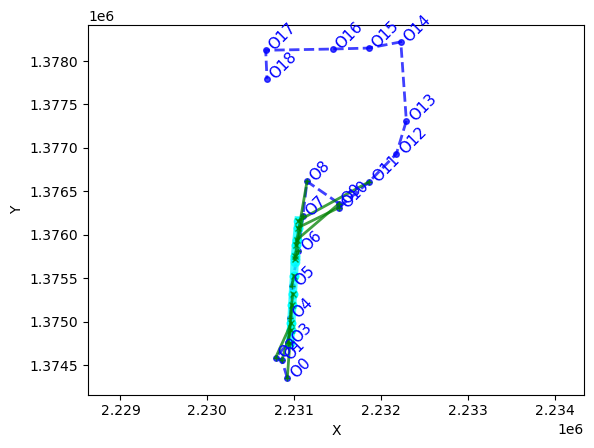

In [150]:
fig, ax = plt.subplots(1, 1)
mmviz.plot_map(map_con, matcher=matcher,
               ax=ax,
               show_labels=True, show_matching=True, show_graph=False,
               filename="my_plot.png")

In [151]:
test = matcher.lattice[4]
m = max(test.values_all(), key=lambda m: m.logprob) # for the 4th point get the one with the highest logprob


In [152]:
m.logprob

-0.2337536369380175

In [161]:
import numpy as np
t = {x.cname.split('_')[0] + '_' + x.cname.split('_')[1]: x.logprob for x in test.values_all()}

In [162]:
check = pd.DataFrame.from_dict(t,orient='index',columns=['logprob']).sort_values('logprob',ascending=False)
check

,logprob
5411630548_69588593,-0.233754
69588593_5428310271,-0.249858
69588593_9659613700,-0.310471
69588593_6303203604,-0.310794
5428310271_69588595,-0.324256
...,...
9819244531_4165942026,-4.502188
4165942034_6702448132,-4.822482
6881448206_5411918864,-4.994783
8481415865_535741308,-5.126322


In [164]:
(check.index == '5424132517_7151205661').sum()

0

In [165]:
testing = trace.copy()
testing.geometry = testing.buffer(1000)
intersect = gpd.overlay(edges,testing)
intersect[(intersect['A_B'] == '5424132517_7151205661') & (intersect['sequence'] == 4)]

,A,B,A_B,osm_bl,osm_pbl,osm_mu,osm_<25mph,osm_25-30mph,osm_>30mph,osm_1lpd,osm_2-3lpd,osm_>4lpd,name,highway,oneway,dist,mins,tup,sequence,geometry
1271,5424132517,7151205661,5424132517_7151205661,0,0,0,0,1,0,0,1,0,Juniper Street Northeast,secondary,yes,142.53,0.2,"(5424132517, 7151205661)",4,"LINESTRING (2231036.034 1376037.255, 2231026.3..."


In [14]:
#reduce the states size with match_nodes
reduced_states = list(set(edges))

#calculate the match ratio
match_ratio = last_matched / (len(gps_trace)-1)
    
#retreive matched edges from network
geos_list = [geos_dict.get(id,0) for id in reduced_states]

#turn into geodataframe
matched_trip = gpd.GeoDataFrame(data={'A_B':reduced_states,'geometry':geos_list},geometry='geometry',crs='epsg:2240')

#turn tuple to str
matched_trip['A_B'] = matched_trip['A_B'].apply(lambda row: f'{row[0]}_{row[1]}')

#reset index to add an edge sequence column
matched_trip.reset_index().rename(columns={'index':'edge_sequence'},inplace=True)

trace['interpolated_point'] = pd.Series([ Point(x.edge_m.pi) for x in matcher.lattice_best ])
trace = trace.loc[0:last_matched]
trace['match_lines'] = trace.apply(lambda row: LineString([row['geometry'],row['interpolated_point']]),axis=1)

interpolated_points = trace[['sequence','interpolated_point']]
interpolated_points = gpd.GeoDataFrame(interpolated_points,geometry='interpolated_point')

match_lines = trace[['sequence','match_lines']]
match_lines = gpd.GeoDataFrame(match_lines,geometry='match_lines')
match_lines['length'] = match_lines.length

c:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
c:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


(None, <AxesSubplot: xlabel='X', ylabel='Y'>)

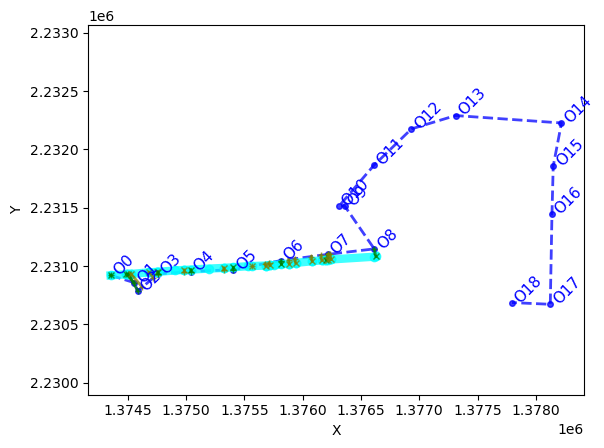

In [ ]:

interpolated_points.to_file(project_dir/f"single_example/{tripid}.gpkg",layer='interpolated_points')
match_lines.to_file(project_dir/f"single_example/{tripid}.gpkg",layer='match_lines')

#%%






